# Neurons

Neurons are the fundamental computational units in `brainpy.state`. This document explains how neurons work, what models are available, and how to use and create them.

## Overview

In `brainpy.state`, neurons model the dynamics of neural populations. Each neuron model:

- Maintains **membrane potential** (voltage)
- Integrates **input currents**
- Generates **spikes** when threshold is crossed
- **Resets** after spiking (various strategies)

All neuron models inherit from the base `Neuron` class and follow consistent interfaces.

## Basic Usage

### Creating Neurons

In [62]:
import numpy as np

import brainpy
import brainstate
import braintools
import brainunit as u
import jax.numpy as jnp

In [63]:
brainstate.environ.set(dt=0.1 * u.ms)

In [64]:
# Create a population of 100 LIF neurons
neurons = brainpy.state.LIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms
)

### Initializing States

Before simulation, initialize neuron states:

In [65]:
# Initialize all states to default values
brainstate.nn.init_all_states(neurons)

# Or with specific batch in_size
brainstate.nn.init_all_states(neurons, batch_size=32)

LIF(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=10. * msecond,
  V_th=-50. * mvolt,
  V_rest=-65. * mvolt,
  V_reset=-65. * mvolt,
  V_initializer=Constant(value=0.0 * mvolt),
  V=HiddenState(
    value=~float32[32,100] * mvolt
  )
)

### Running Neurons

Update neurons by calling them with input current:

In [66]:
# Single time step - provide input for all neurons
# Create input current array matching neuron population in_size
input_current = jnp.ones(100) * 2.0 * u.nA  # 100 neurons, each gets 2.0 nA

# Access results
voltage = neurons.V.value          # Membrane potential
spikes = neurons.get_spike()       # Spike output

print(f"Voltage shape: {voltage.shape}")
print(f"Spikes shape: {spikes.shape}")

Voltage shape: (32, 100)
Spikes shape: (32, 100)


## Available Neuron Models


For more neuron models, see the [API Reference](../../api/index.rst).


### IF (Integrate-and-Fire)

The simplest spiking neuron model.

**Mathematical Model:**


$$
\tau \frac{dV}{dt} = -V + R \cdot I(t)
$$
**Spike condition:** If :$ V \geq V_{th} $, emit spike and reset.

**Example:**

In [67]:
# IF neuron - simple parameters
neuron = brainpy.state.IF(
    in_size=100,
    V_th=1. * u.mV,        # Spike threshold  
    tau=20. * u.ms,        # Membrane time constant
    R=1. * u.ohm           # Input resistance
)

# Initialize the neuron
import brainstate
brainstate.nn.init_all_states(neuron)

IF(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=20. * msecond,
  V_th=1. * mvolt,
  V_initializer=Constant(value=0.0 * mvolt),
  V=HiddenState(
    value=~float32[100] * mvolt
  )
)

**Parameters:**

- `in_size`: Number of neurons
- `V_rest`: Resting potential
- `V_th`: Spike threshold
- `V_reset`: Reset potential after spike
- `tau`: Membrane time constant
- `R`: Input resistance

**Use cases:**

- Simple rate coding
- Fast simulations
- Theoretical studies

### LIF (Leaky Integrate-and-Fire)

The most commonly used spiking neuron model.

**Mathematical Model:**


$$
\tau \frac{dV}{dt} = -(V - V_{rest}) + R \cdot I(t)
$$
**Spike condition:** If :$V \geq V_{th}$, emit spike and reset.

**Example:**

In [68]:
neuron = brainpy.state.LIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    R=1. * u.ohm,
    V_initializer=braintools.init.Normal(-65., 5., unit=u.mV)
)

# Initialize the neuron
brainstate.nn.init_all_states(neuron)

LIF(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=10. * msecond,
  V_th=-50. * mvolt,
  V_rest=-65. * mvolt,
  V_reset=-65. * mvolt,
  V_initializer=Normal(mean=-65.0, std=5.0),
  V=HiddenState(
    value=float32[100] * mvolt
  )
)

**Parameters:**

All IF parameters, plus:

- `V_initializer`: How to initialize membrane potential

**Key Features:**

- Leak toward resting potential
- Realistic temporal integration
- Well-studied dynamics

**Use cases:**

- General spiking neural networks
- Cortical neuron modeling
- Learning and training

### LIFRef (LIF with Refractory Period)

LIF neuron with absolute refractory period.

**Mathematical Model:**

Same as LIF, but after spiking:

- Neuron is "frozen" for refractory period
- No integration during refractory period
- More biologically realistic

**Example:**

In [69]:
neuron = brainpy.state.LIFRef(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    tau_ref=2. * u.ms,  # Refractory period
    R=1. * u.ohm
)

# Initialize the neuron
brainstate.nn.init_all_states(neuron)

LIFRef(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=10. * msecond,
  tau_ref=2. * msecond,
  V_th=-50. * mvolt,
  V_rest=-65. * mvolt,
  V_reset=-65. * mvolt,
  V_initializer=Constant(value=0.0 * mvolt),
  V=HiddenState(
    value=~float32[100] * mvolt
  ),
  last_spike_time=ShortTermState(
    value=~float32[100] * msecond
  )
)

**Additional Parameters:**

- `tau_ref`: Refractory period duration

**Key Features:**

- Absolute refractory period
- Prevents immediate re-firing
- More realistic spike timing

**Use cases:**

- Precise temporal coding
- Biological realism
- Rate regulation

### ALIF (Adaptive Leaky Integrate-and-Fire)

LIF with spike-frequency adaptation.

**Mathematical Model:**


$$
\begin{aligned}
\tau \frac{dV}{dt} &= -(V - V_{rest}) - R \cdot w + R \cdot I(t) \\
\tau_w \frac{dw}{dt} &= -w
\end{aligned}
$$
When spike occurs: :$w \leftarrow w + \beta$

**Example:**

In [70]:
neuron = brainpy.state.ALIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    tau_a=200. * u.ms,   # Adaptation time constant
    beta=0.1 * u.nA,        # Spike-triggered adaptation
    R=1. * u.ohm
)

# Initialize the neuron
brainstate.nn.init_all_states(neuron)

ALIF(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=10. * msecond,
  tau_a=200. * msecond,
  V_th=-50. * mvolt,
  V_reset=-65. * mvolt,
  V_rest=-65. * mvolt,
  beta=0.1 * namp,
  V_initializer=Constant(value=0.0 * mvolt),
  a_initializer=Constant(value=0.0),
  V=HiddenState(
    value=~float32[100] * mvolt
  ),
  a=HiddenState(
    value=ShapedArray(float32[100], weak_type=True)
  )
)

**Additional Parameters:**

- `tau_w`: Adaptation time constant
- `beta`: Adaptation increment per spike

**Key Features:**

- Spike-frequency adaptation
- Reduced firing with sustained input
- More complex dynamics

**Use cases:**

- Cortical neuron modeling
- Sensory adaptation
- Complex temporal patterns

## Reset Modes

BrainPy supports different reset behaviors after spiking:

### Soft Reset (Default)

Subtract threshold from membrane potential:


$$
V \leftarrow V - V_{th}
$$

In [71]:
neuron = brainpy.state.LIF(
    in_size=100, 
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    spk_reset='soft'
)

brainstate.nn.init_all_states(neuron)

LIF(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=10. * msecond,
  V_th=-50. * mvolt,
  V_rest=-65. * mvolt,
  V_reset=-65. * mvolt,
  V_initializer=Constant(value=0.0 * mvolt),
  V=HiddenState(
    value=~float32[100] * mvolt
  )
)

**Properties:**

- Preserves extra charge above threshold
- Allows rapid re-firing
- Common in machine learning

### Hard Reset

Reset to fixed potential:


$$
V \leftarrow V_{reset}
$$

In [72]:
neuron = brainpy.state.LIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    spk_reset='hard'
)

brainstate.nn.init_all_states(neuron)

LIF(
  in_size=(100,),
  out_size=(100,),
  spk_reset=hard,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=10. * msecond,
  V_th=-50. * mvolt,
  V_rest=-65. * mvolt,
  V_reset=-65. * mvolt,
  V_initializer=Constant(value=0.0 * mvolt),
  V=HiddenState(
    value=~float32[100] * mvolt
  )
)

**Properties:**

- Discards extra charge
- More biologically realistic
- Prevents immediate re-firing

### Choosing Reset Mode

- **Soft reset**: Machine learning, rate coding, fast oscillations
- **Hard reset**: Biological modeling, temporal coding, realism

## Spike Functions

For training spiking neural networks, use surrogate gradients:

In [73]:
neuron = brainpy.state.LIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    spk_fun=braintools.surrogate.ReluGrad()
)

brainstate.nn.init_all_states(neuron)

LIF(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=10. * msecond,
  V_th=-50. * mvolt,
  V_rest=-65. * mvolt,
  V_reset=-65. * mvolt,
  V_initializer=Constant(value=0.0 * mvolt),
  V=HiddenState(
    value=~float32[100] * mvolt
  )
)

Available surrogate functions:

- `ReluGrad()`: ReLU-like gradient
- `SigmoidGrad()`: Sigmoid-like gradient
- `GaussianGrad()`: Gaussian-like gradient
- `SuperSpike()`: SuperSpike surrogate

See Tutorial 3 for training details.

## Advanced Features

### Initialization Strategies

Different ways to initialize membrane potential:

In [74]:
# Constant initialization
neuron1 = brainpy.state.LIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    tau=10. * u.ms,
    V_initializer=braintools.init.Constant(-65., unit=u.mV)
)
brainstate.nn.init_all_states(neuron1)

# Normal distribution
neuron2 = brainpy.state.LIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    tau=10. * u.ms,
    V_initializer=braintools.init.Normal(-65., 5., unit=u.mV)
)
brainstate.nn.init_all_states(neuron2)

# Uniform distribution
neuron3 = brainpy.state.LIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    tau=10. * u.ms,
    V_initializer=braintools.init.Uniform(-70., -60., unit=u.mV)
)
brainstate.nn.init_all_states(neuron3)

LIF(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  R=1. * ohm,
  tau=10. * msecond,
  V_th=-50. * mvolt,
  V_rest=-65. * mvolt,
  V_reset=0. * mvolt,
  V_initializer=Uniform(low=-70.0, high=-60.0),
  V=HiddenState(
    value=float32[100] * mvolt
  )
)

### Accessing Neuron States

In [75]:
# Membrane potential (with units)
voltage = neuron.V.value  # Quantity with units

# Spike output (binary or real-valued)
spikes = neuron.get_spike()

# Access underlying array (without units)
voltage_array = neuron.V.value.to_decimal(u.mV)

### Batched Simulation

Simulate multiple trials in parallel:

In [76]:
# Initialize with batch dimension
brainstate.nn.init_all_states(neuron, batch_size=32)

# Input shape: (batch_in_size, in_size)
# For 32 batches of 100 neurons each
input_current = jnp.ones((32, 100)) * 2.0 * u.nA
neuron(input_current)

# Output shape: (batch_in_size, in_size)
spikes = neuron.get_spike()
print(f"Spikes shape: {spikes.shape}")  # Should be (32, 100)

Spikes shape: (32, 100)


## Complete Example

Here's a complete example simulating a LIF neuron:

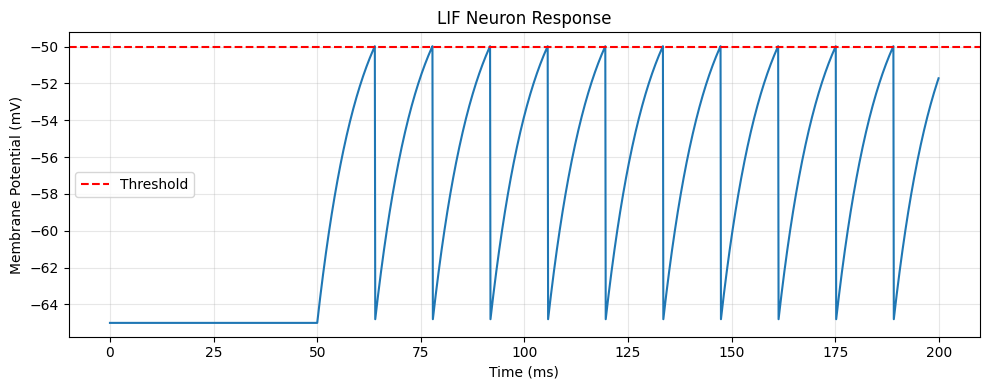

In [77]:
import matplotlib.pyplot as plt

# Set time step
brainstate.environ.set(dt=0.1 * u.ms)

# Create neuron
neuron = brainpy.state.LIF(
    in_size=1,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    spk_reset='hard'
)

# Initialize
brainstate.nn.init_all_states(neuron)

# Simulation parameters
duration = 200. * u.ms
dt = brainstate.environ.get_dt()
times = u.math.arange(0. * u.ms, duration, dt)

# Input current (step input)
def get_input():
    t = brainstate.environ.get('t')
    return u.math.where(
        t > 50*u.ms,
        jnp.ones(1) * 20.0 * u.mA,  # Array of in_size 1
        jnp.zeros(1) * u.mA,  # Array of in_size 1
    )

def step_run(i, t):
    with brainstate.environ.context(i=i, t=t):
        neuron(get_input())
        return neuron.V.value, neuron.get_spike()

# Run simulation
voltages, spikes = brainstate.transform.for_loop(step_run, jnp.arange(times.size), times)

# Plot results
voltages = u.math.asarray(voltages)
times_plot = times.to_decimal(u.ms)
voltages_plot = voltages.to_decimal(u.mV).squeeze()  # Remove in_size dimension

plt.figure(figsize=(10, 4))
plt.plot(times_plot, voltages_plot)
plt.axhline(y=-50, color='r', linestyle='--', label='Threshold')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('LIF Neuron Response')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Creating Custom Neurons

You can create custom neuron models by inheriting from `Neuron`:

In [78]:
from brainpy.state import Neuron

class MyNeuron(Neuron):
    def __init__(self, in_size, tau, V_th, **kwargs):
        super().__init__(in_size, **kwargs)

        # Store parameters
        self.tau = tau
        self.V_th = V_th

        # Initialize states
        self.V = brainstate.ShortTermState(
            braintools.init.Constant(0., unit=u.mV)(in_size)
        )
        self.spike = brainstate.ShortTermState(
            jnp.zeros(in_size)
        )

    def update(self, x):
        # Get time step
        dt = brainstate.environ.get_dt()

        # Update membrane potential (custom dynamics)
        dV = (-self.V.value + x) / self.tau * dt
        V_new = self.V.value + dV

        # Check for spikes
        spike = (V_new >= self.V_th).astype(float)

        # Reset
        V_new = jnp.where(spike > 0, 0. * u.mV, V_new)

        # Update states
        self.V.value = V_new
        self.spike.value = spike

        return spike

    def get_spike(self):
        return self.spike.value

Usage:

In [79]:
neuron = MyNeuron(in_size=100, tau=10*u.ms, V_th=1*u.mV)
brainstate.nn.init_all_states(neuron)

# Create appropriate input current
input_current = jnp.ones(100) * 0.5 * u.nA

## Performance Tips

1. **Use JIT compilation** for repeated simulations:

In [80]:
@brainstate.transform.jit
def simulate_step(input):
    neuron(input)
    return neuron.V.value

2. **Batch multiple trials** for parallelism:

In [81]:
brainstate.nn.init_all_states(neuron, batch_size=100)

MyNeuron(
  in_size=(100,),
  out_size=(100,),
  spk_reset=soft,
  spk_fun=InvSquareGrad(alpha=100.0),
  tau=10 * msecond,
  V_th=1 * mvolt,
  V=ShortTermState(
    value=~float32[100] * mvolt
  ),
  spike=ShortTermState(
    value=ShapedArray(float32[100])
  )
)

3. **Use appropriate data types**:

In [82]:
# Float32 is usually sufficient and faster
brainstate.environ.set(precision=32)

4. Use soft reset for higher firing rates:

In [83]:
# Use soft reset for higher firing rates
neuron = brainpy.state.LIF(100, tau=10*u.ms, spk_reset='soft')

5. Use hard reset for precise spike timing:

In [84]:
# Use refractory period for precise timing
neuron = brainpy.state.LIFRef(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    tau_ref=2. * u.ms,
    spk_reset='hard'
)

6. Use refractory period for precise timing

In [85]:
neuron = brainpy.state.LIFRef(
    100,
    tau=10*u.ms,
    tau_ref=2*u.ms,
    spk_reset='hard'
)

7. Adaptation creates bursting patterns

In [89]:
neuron = brainpy.state.ALIF(
    in_size=100,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    tau_a=200. * u.ms,
    spk_reset='soft'
)
brainstate.nn.init_all_states(neuron)

# Adaptation creates bursting patterns
neuron = brainpy.state.ALIF(
    100,
    tau=10*u.ms,
    tau_a=200*u.ms,
    beta=0.01,
    spk_reset='soft'
)

## Summary

Neurons in `brainpy.state`:

✅ **Multiple models**: IF, LIF, LIFRef, ALIF

✅ **Physical units**: All parameters with proper units

✅ **Flexible reset**: Soft or hard reset modes

✅ **Training-ready**: Surrogate gradients for learning

✅ **High performance**: JIT compilation and batching

✅ **Extensible**: Easy to create custom models

## Next Steps

- Learn about synapses to connect neurons
- Explore projections for network connectivity
- Follow tutorials for hands-on practice
- See docs for network examples